In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
active_stations = session.query(stations.station).all()
active_stations

[('USC00519397',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519523',),
 ('USC00519281',),
 ('USC00511918',),
 ('USC00516128',)]

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date_str = session.query(measurements.date).order_by(measurements.date.desc()).first()[0]
most_recent_date_str

'2017-08-23'

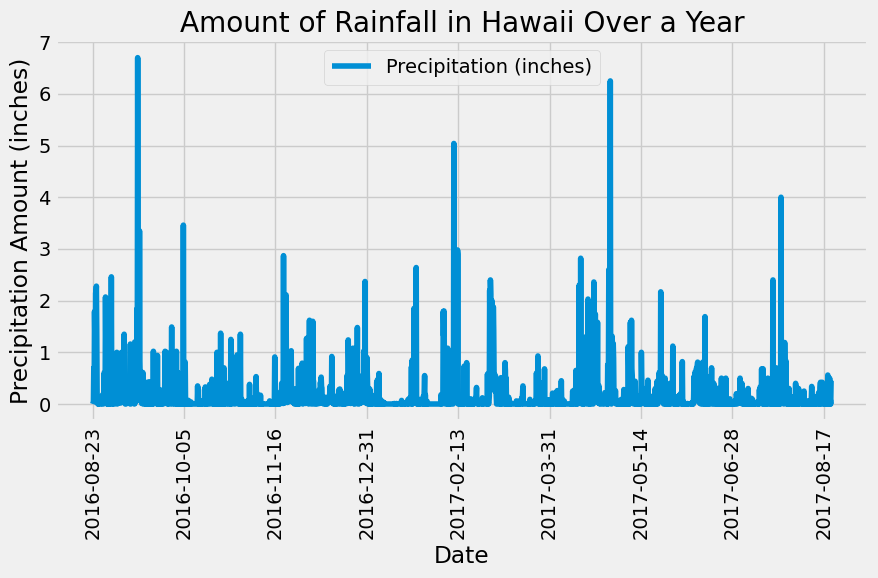

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(most_recent_date_str, '%Y-%m-%d')
query_date = dt.date(most_recent_date.year - 1, most_recent_date.month, most_recent_date.day)

# Perform a query to retrieve the data and precipitation scores
date_and_precip_data = session.query(measurements.date, measurements.prcp).\
    filter(measurements.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(date_and_precip_data, columns = ['Date (YYYY-MM-DD)', 'Precipitation (inches)']).dropna()

# Sort the dataframe by date
df_sorted_by_date = df.sort_values('Date (YYYY-MM-DD)', ascending = True)
df_sorted_by_date.set_index('Date (YYYY-MM-DD)', inplace=True)
df_sorted_by_date.head(5)

# Use Pandas Plotting with Matplotlib to plot the data
ax = df_sorted_by_date.plot(rot = 90, title = "Amount of Rainfall in Hawaii Over a Year", xlabel='Date', ylabel = "Precipitation Amount (inches)", figsize=(9,6))
plt.tight_layout()
plt.show()
ax.figure.savefig('images/annual_precipitation_hawaii.png', bbox_inches='tight')

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_sorted_by_date.describe()

,Precipitation (inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(stations.station)).all()
total_stations

[(9,)]

In [14]:
# Design a query (with join) to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query_tables_with_join = session.query(stations.station, func.count(stations.station)).filter(stations.station == measurements.station).\
    group_by(stations.station).\
    order_by(func.count(stations.station).desc()).all()

query_tables_with_join

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Design a query (without join) to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(measurements.station, func.count(measurements.station)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Storing the most active station id as a variable
most_active_station_id = station_activity[0][0]
most_active_station_id

'USC00519281'

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_data = session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
    filter(measurements.station == most_active_station_id).all()

most_active_station_data

[(54.0, 85.0, 71.66378066378067)]

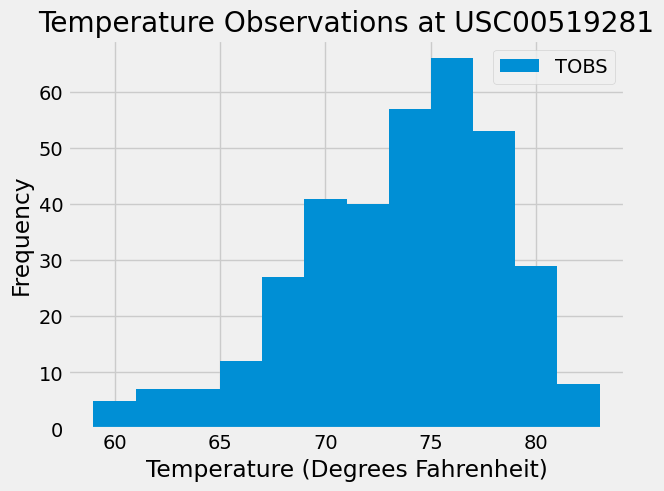

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [measurements.date, measurements.tobs]
station_temps = session.query(*sel).\
        filter(func.strftime(measurements.date) >= query_date, measurements.station == most_active_station_id).\
        group_by(measurements.date).\
        order_by(measurements.date).all()

station_temps_df = pd.DataFrame(station_temps, columns = ['Measurement Date', 'Temperature'])

plt.hist(station_temps_df['Temperature'], bins = 12, density = False, label = "TOBS")
plt.xlabel("Temperature (Degrees Fahrenheit)")
plt.ylabel("Frequency")
plt.legend()
plt.title(f"Temperature Observations at {most_active_station_id}")
plt.figsize=(10,7)
plt.savefig('images/annual_temps_at_most_active_station.png',bbox_inches='tight')
plt.show()

# Close Session

In [19]:
# Close Session
session.close()